In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_log_error, make_scorer
from xgboost import XGBRegressor

In [5]:
%matplotlib inline
sns.set()

In [8]:
import pickle
with open('../count-power-transformer.pkl', 'rb') as inf:
    pt = pickle.load(inf)
z = zipfile.ZipFile('../bike-sharing-demand.zip')
data = pd.read_csv(z.open('test.csv'), encoding='utf8', parse_dates=[0])
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [9]:
data.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
dtype: object

In [10]:
data.isna().any()

datetime      False
season        False
holiday       False
workingday    False
weather       False
temp          False
atemp         False
humidity      False
windspeed     False
dtype: bool

In [11]:
season = pd.get_dummies(data['season'],prefix='season')
weather = pd.get_dummies(data['weather'],prefix='weather')
data = pd.concat([data, season, weather],axis=1)
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,1,0,0,0,1,0,0,0
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0


In [13]:
date_time_splitting = data.datetime.map(
    lambda t: [t.year, t.month, t.day, t.hour, t.weekday()]
)
date_time = date_time_splitting.apply(pd.Series)
date_time.columns = ['year', 'month', 'day', 'hour', 'weekday']
data = pd.concat([data, date_time],axis=1)
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,season_1,...,season_4,weather_1,weather_2,weather_3,weather_4,year,month,day,hour,weekday
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,1,...,0,1,0,0,0,2011,1,20,0,3
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,...,0,1,0,0,0,2011,1,20,1,3
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,...,0,1,0,0,0,2011,1,20,2,3
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,1,...,0,1,0,0,0,2011,1,20,3,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,1,...,0,1,0,0,0,2011,1,20,4,3


In [14]:
with open('../windspeed-random-forest.pkl', 'rb') as inf:
    rfr = pickle.load(inf)
rfr

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [16]:
wind_speed_features = [
    "season_1", "season_2", "season_3", "season_4",
    "weather_1", "weather_2", "weather_3", "weather_4",
    "humidity", "temp", "atemp", "year", "month"
]
wind_speed_missing = data.loc[data.windspeed == 0, wind_speed_features]
wind_speed_estimation = rfr.predict(wind_speed_missing)
data.loc[data.windspeed == 0, 'windspeed'] = wind_speed_estimation

Text(0.5, 0, 'filled wind speed')

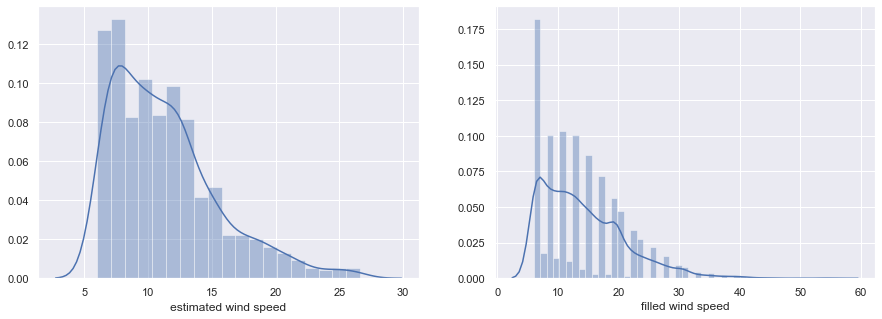

In [19]:
f, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.distplot(wind_speed_estimation, ax=axes[0])
axes[0].set_xlabel('estimated wind speed')
sns.distplot(data.windspeed, ax=axes[1])
axes[1].set_xlabel('filled wind speed')

In [20]:
features = [
    'season_1', 'season_2', 'season_3', 'season_4',
    'weather_1', 'weather_2', 'weather_3', 'weather_4',
    'year', 'month', 'weekday', 'hour',
    'holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed',
]
x = data[features]
x.shape

(6493, 18)

In [21]:
with open('../xgb_best.pkl', 'rb') as inf:
    model = pickle.load(inf)
model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.4,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=9, missing=nan, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.8, verbosity=1)

In [32]:
pred = model.predict(x)
pred = pt.inverse_transform(pred.reshape(-1, 1)).flatten()
pred[:10]

array([ 10.966216 ,   4.4830074,   2.8218184,   1.7866478,   1.8968242,
         6.0172353,  35.075848 ,  99.10786  , 222.55083  , 115.10229  ],
      dtype=float32)

In [33]:
result = pd.DataFrame({
    'datetime': data.datetime,
    'count': pred,
})
result.head()

,datetime,count
0,2011-01-20 00:00:00,10.966216
1,2011-01-20 01:00:00,4.483007
2,2011-01-20 02:00:00,2.821818
3,2011-01-20 03:00:00,1.786648
4,2011-01-20 04:00:00,1.896824


In [34]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 2 columns):
datetime    6493 non-null datetime64[ns]
count       6493 non-null float32
dtypes: datetime64[ns](1), float32(1)
memory usage: 76.2 KB


In [35]:
result.to_csv('../submission.csv', index=False)